<a href="https://colab.research.google.com/github/WhiteTeaDragon/SingularValues/blob/main/TT/PerformanceExperimentsTT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import functions
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [ ]:
import importlib
importlib.reload(functions)

<module 'functions' from '/content/functions.py'>

Время на обучение у разных моделей может отличаться -- это происходит из-за того, что они обучались в разных сессиях Google Colab.

In [ ]:
def plot_final_graph(addition="", third=True, ylim_loss=4, ylim_error=1):
    history_no_clipping = pickle.load(open(addition + 'trainHistoryDict', "rb"))
    history_05 = pickle.load(open(addition + 'trainHistoryDict_clip_05', "rb"))
    if third:
        history_1 = pickle.load(open(addition + 'trainHistoryDict_clip_1', "rb"))
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].grid(True)
    axs[1].grid(True)
    max_len = len(history_no_clipping['val_loss'])
    axs[0].plot(history_no_clipping['val_loss'][4:max_len:5], label='no clipping')
    axs[0].plot(history_05['val_loss'][4:max_len:5], label='0.5')
    if third:
        axs[0].plot(history_1['val_loss'][4:max_len:5], label='1')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylim(0, ylim_loss)
    axs[1].plot(1 - np.array(history_no_clipping['val_acc'][4:max_len:5]), label='no clipping')
    axs[1].plot(1 - np.array(history_05['val_acc'][4:max_len:5]), label='0.5')
    if third:
        axs[1].plot(1 - np.array(history_1['val_acc'][4:max_len:5]), label='1')
    axs[1].set_title('Error')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylim(0, ylim_error)
    axs[0].legend(loc='best')
    axs[1].legend(loc='best')

### Loading Data

In [ ]:
num_classes = 10

# load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


### Without decomposition

#### Model without clipping

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(input_shape)
model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

In [ ]:
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'simple_trainHistoryDict', steps_per_epoch=100,
                       batch_size=100, epochs=1000)

Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch 1/1000
Learning rate:  0.001
100/100 [==============================] - 41s 83ms/step - loss: 2.7917 - acc: 0.2219 - val_loss: 2.3573 - val_acc: 0.2291

Epoch 00001: val_acc improved from -inf to 0.22910, saving model to /content/saved_models/cifar10_ResNet32v1_model.001.h5
Epoch 2/1000
Learning rate:  0.001
100/100 [==============================] - 7s 73ms/step - loss: 1.8881 - acc: 0.3917 - val_loss: 2.0455 - val_acc: 0.3656

Epoch 00002: val_acc improved from 0.22910 to 0.36560, saving model to /content/saved_models/cifar10_ResNet32v1_model.002.h5
Epoch 3/1000
Learning rate:  0.001
100/100 [==============================] - 7s 72ms/step - loss: 1.7052 - acc: 0.4599 - val_loss: 2.1614 - val_acc: 0.3371

Epoch 00003: val_acc did not improve from 0.36560
Epoch 4/1000
Learning rate:  0.001
100/100 [==============================] - 7s 72ms/step - loss: 1.6138 - acc: 0.5131 - val_loss: 1.8819 - val_acc: 0.4220

Ep

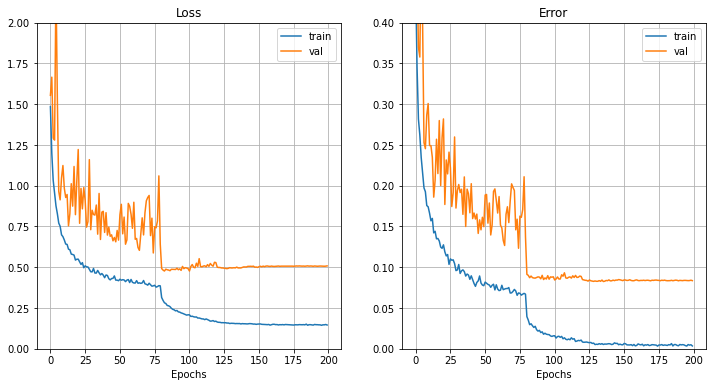

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('simple_trainHistoryDict', "rb"))
functions.plot_loss_acc(history, 2, 0.4)

In [ ]:
history['val_acc'][-1]

0.9164000153541565

In [ ]:
1 - history['val_acc'][-1]

0.0835999846458435

#### Model with clipping to 0.5

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(input_shape)

Learning rate:  0.001


In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(0.5, "simple")]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'simple_trainHistoryDict_clip_05', steps_per_epoch=100, epochs=1000,
                       batch_size=100,
                       callbacks=callbacks)

Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch 1/1000
Learning rate:  0.001
100/100 [==============================] - 11s 80ms/step - loss: 2.4961 - acc: 0.2745 - val_loss: 2.3687 - val_acc: 0.2634

Epoch 00001: val_acc improved from -inf to 0.26340, saving model to /content/saved_models/cifar10_ResNet32v1_model.001.h5
Epoch 2/1000
Learning rate:  0.001
100/100 [==============================] - 7s 73ms/step - loss: 2.0267 - acc: 0.2734 - val_loss: 3.5508 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.26340
Epoch 3/1000
Learning rate:  0.001
100/100 [==============================] - 7s 73ms/step - loss: 1.6703 - acc: 0.3801 - val_loss: 4.0442 - val_acc: 0.1000

Epoch 00003: val_acc did not improve from 0.26340
Epoch 4/1000
Learning rate:  0.001
100/100 [==============================] - 7s 73ms/step - loss: 1.4953 - acc: 0.4573 - val_loss: 3.7763 - val_acc: 0.1020

Epoch 00004: val_acc did not improve from 0.26340
Epoch 5/1000
Learning rate:

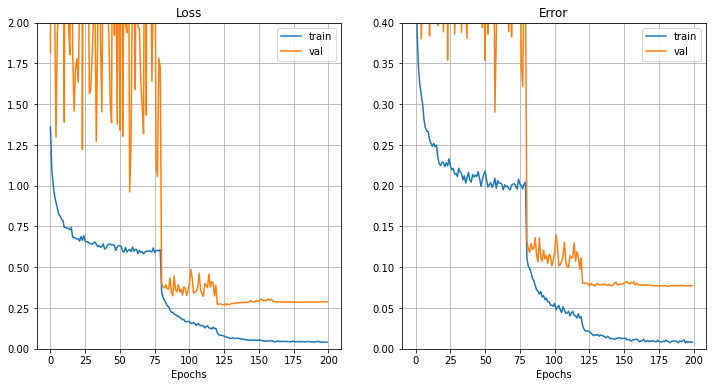

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('simple_trainHistoryDict_clip_05', "rb"))
functions.plot_loss_acc(history, 2, 0.4)

In [ ]:
history['val_acc'][-1]

0.9223999977111816

In [ ]:
1 - history['val_acc'][-1]

0.07760000228881836

#### Model with clipping to 1

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(input_shape)

Learning rate:  0.001


In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(1, "simple")]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'simple_trainHistoryDict_clip_1', steps_per_epoch=100, epochs=1000,
                       batch_size=100,
                       callbacks=callbacks)

Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch 1/1000
Learning rate:  0.001
100/100 [==============================] - 12s 84ms/step - loss: 3.4927 - acc: 0.2104 - val_loss: 3.0568 - val_acc: 0.1511

Epoch 00001: val_acc improved from -inf to 0.15110, saving model to /content/saved_models/cifar10_ResNet32v1_model.001.h5
Epoch 2/1000
Learning rate:  0.001
100/100 [==============================] - 7s 75ms/step - loss: 1.8758 - acc: 0.3446 - val_loss: 3.4404 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.15110
Epoch 3/1000
Learning rate:  0.001
100/100 [==============================] - 7s 74ms/step - loss: 1.6200 - acc: 0.4300 - val_loss: 4.0561 - val_acc: 0.1126

Epoch 00003: val_acc did not improve from 0.15110
Epoch 4/1000
Learning rate:  0.001
100/100 [==============================] - 8s 76ms/step - loss: 1.5210 - acc: 0.4705 - val_loss: 2.6097 - val_acc: 0.1881

Epoch 00004: val_acc improved from 0.15110 to 0.18810, saving model to /conte

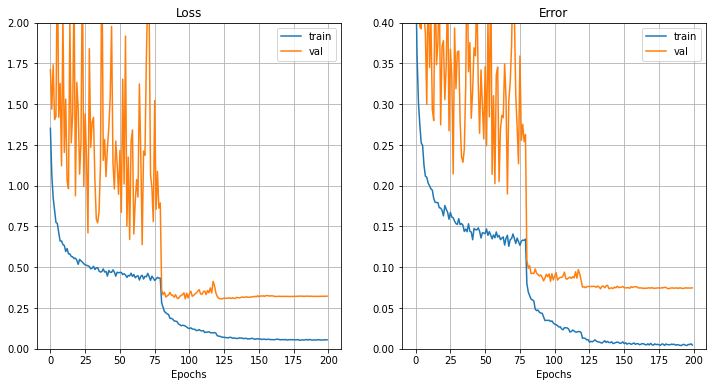

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('simple_trainHistoryDict_clip_1', "rb"))
functions.plot_loss_acc(history, 2, 0.4)

In [ ]:
history['val_acc'][-1]

0.9253000020980835

In [ ]:
1 - history['val_acc'][-1]

0.0746999979019165

#### Plotting final graph

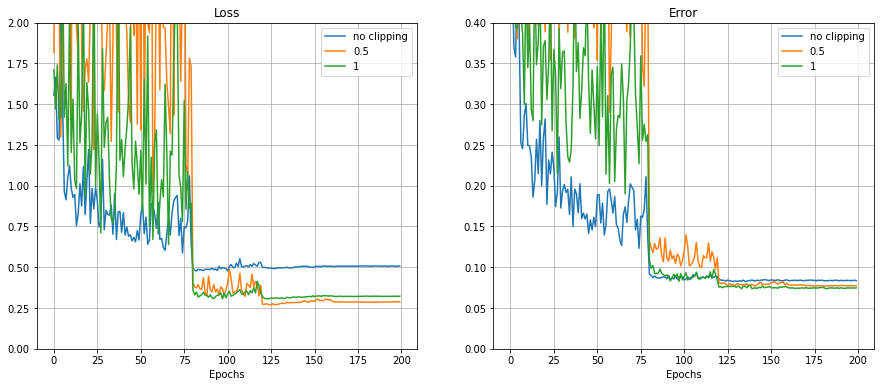

In [ ]:
plot_final_graph("simple_", ylim_loss=2, ylim_error=0.4)

### decomposition_rank = 1

#### Model without clipping

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.ConvDecomposed2D, decomposition_rank=1)
model.summary()

Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_decomposed2d (ConvDecompos (None, 32, 32, 16)   44          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 32, 32, 16)   64          conv_decomposed2d[0][0]          
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 32, 32, 16)   0           batch_normalization_31[0][0]     
______________________________________________________________________

In [ ]:
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'trainHistoryDict', steps_per_epoch=100, batch_size=100,
                       epochs=1000)

Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch 1/1000
Learning rate:  0.001
100/100 [==============================] - 16s 92ms/step - loss: 10.8550 - acc: 0.1040 - val_loss: 3.0238 - val_acc: 0.0999

Epoch 00001: val_acc improved from -inf to 0.09990, saving model to /content/saved_models/cifar10_ResNet32v1_model.001.h5
Epoch 2/1000
Learning rate:  0.001
100/100 [==============================] - 8s 79ms/step - loss: 2.5438 - acc: 0.1425 - val_loss: 2.7135 - val_acc: 0.0948

Epoch 00002: val_acc did not improve from 0.09990
Epoch 3/1000
Learning rate:  0.001
100/100 [==============================] - 8s 80ms/step - loss: 2.4509 - acc: 0.1508 - val_loss: 2.6739 - val_acc: 0.1015

Epoch 00003: val_acc improved from 0.09990 to 0.10150, saving model to /content/saved_models/cifar10_ResNet32v1_model.003.h5
Epoch 4/1000
Learning rate:  0.001
100/100 [==============================] - 8s 80ms/step - loss: 2.3849 - acc: 0.1678 - val_loss: 2.5002 - val_acc: 0.1228

E

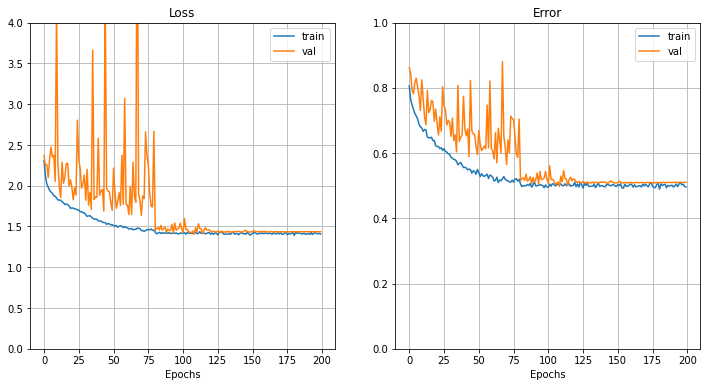

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('trainHistoryDict', "rb"))
functions.plot_loss_acc(history, 4, 1)

In [ ]:
history['val_acc'][-1]

0.4896000027656555

In [ ]:
1 - history['val_acc'][-1]

0.5103999972343445

#### Model with clipping to 0.5

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.ConvDecomposed2D, decomposition_rank=1)

Learning rate:  0.001


In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(0.5)]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'trainHistoryDict_clip_05', steps_per_epoch=100, epochs=1000,
                       batch_size=100,
                       callbacks=callbacks)

Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch 1/1000
Learning rate:  0.001
100/100 [==============================] - 49s 100ms/step - loss: 5.7928 - acc: 0.1196 - val_loss: 2.7750 - val_acc: 0.1000

Epoch 00001: val_acc improved from -inf to 0.10000, saving model to /content/saved_models/cifar10_ResNet32v1_model.001.h5
Epoch 2/1000
Learning rate:  0.001
100/100 [==============================] - 8s 82ms/step - loss: 2.2915 - acc: 0.1333 - val_loss: 2.3377 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.10000
Epoch 3/1000
Learning rate:  0.001
100/100 [==============================] - 8s 81ms/step - loss: 2.1409 - acc: 0.1727 - val_loss: 2.3374 - val_acc: 0.1000

Epoch 00003: val_acc did not improve from 0.10000
Epoch 4/1000
Learning rate:  0.001
100/100 [==============================] - 8s 83ms/step - loss: 2.0435 - acc: 0.2170 - val_loss: 2.3484 - val_acc: 0.1000

Epoch 00004: val_acc did not improve from 0.10000
Epoch 5/1000
Learning rate

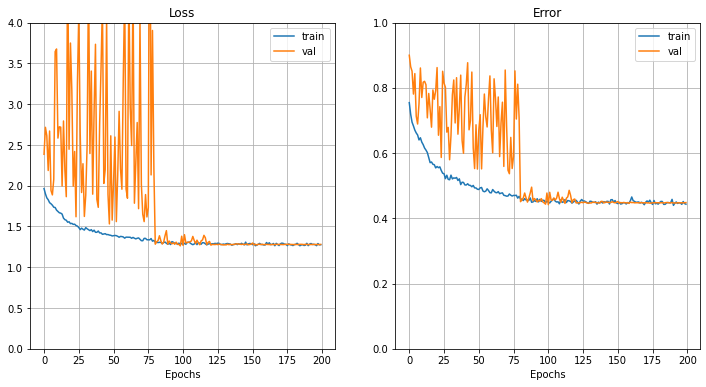

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('trainHistoryDict_clip_05', "rb"))
functions.plot_loss_acc(history, 4, 1)

In [ ]:
history['val_acc'][-1]

0.5516999959945679

In [ ]:
1 - history['val_acc'][-1]

0.44830000400543213

#### Model with clipping to 1

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.ConvDecomposed2D, decomposition_rank=1)

Learning rate:  0.001


In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(1)]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'trainHistoryDict_clip_1', steps_per_epoch=100, epochs=500,
                       batch_size=100,
                       callbacks=callbacks)

Using real-time data augmentation.
Epoch 1/500
Learning rate:  0.001
100/100 [==============================] - 57s 193ms/step - loss: 3.1949 - acc: 0.1217 - val_loss: 2.6224 - val_acc: 0.1080

Epoch 00001: val_acc improved from -inf to 0.10800, saving model to /content/saved_models/cifar10_ResNet32v1_model.001.h5
Epoch 2/500
Learning rate:  0.001
100/100 [==============================] - 17s 167ms/step - loss: 2.2874 - acc: 0.1331 - val_loss: 2.3819 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.10800
Epoch 3/500
Learning rate:  0.001
100/100 [==============================] - 17s 168ms/step - loss: 2.1845 - acc: 0.1830 - val_loss: 2.3803 - val_acc: 0.1000

Epoch 00003: val_acc did not improve from 0.10800
Epoch 4/500
Learning rate:  0.001
100/100 [==============================] - 17s 167ms/step - loss: 2.1460 - acc: 0.1859 - val_loss: 2.4163 - val_acc: 0.1000

Epoch 00004: val_acc did not improve from 0.10800
Epoch 5/500
Learning rate:  0.001
100/100 [==============

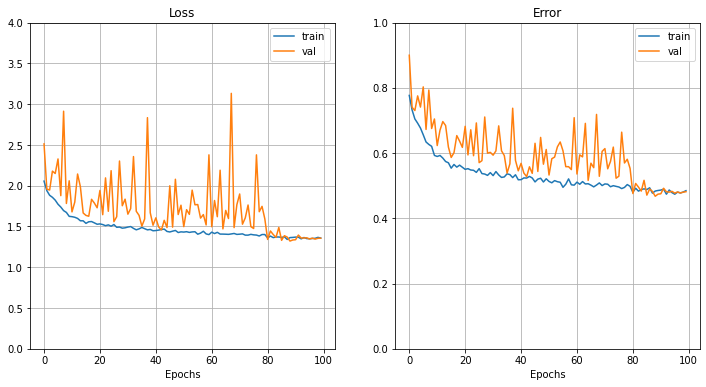

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('trainHistoryDict_clip_1', "rb"))
functions.plot_loss_acc(history, 4, 1)

In [ ]:
1 - history['val_acc'][-1]

0.48170000314712524

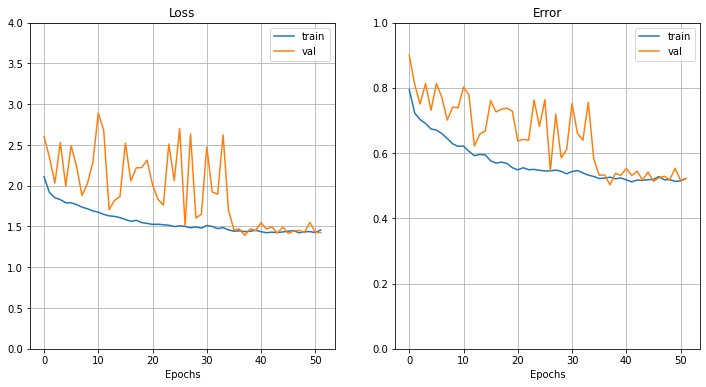

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('trainHistoryDict_clip_1', "rb"))
functions.plot_loss_acc(history, 4, 1)

In [ ]:
1 - history['val_acc'][-1]

0.5221000015735626

#### Plotting final graph

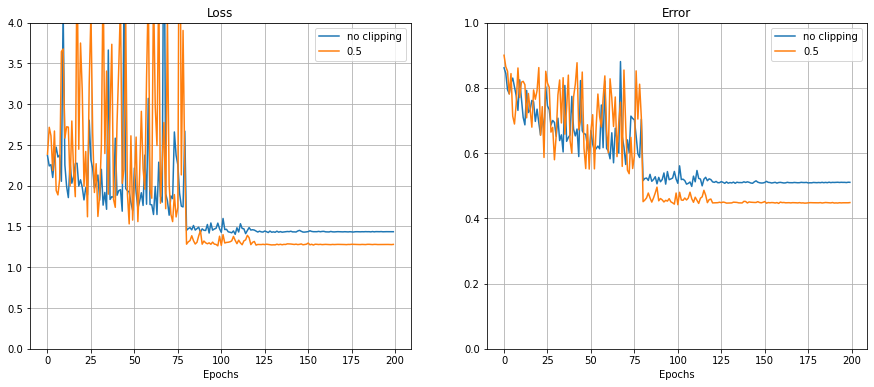

In [ ]:
plot_final_graph(third=False)

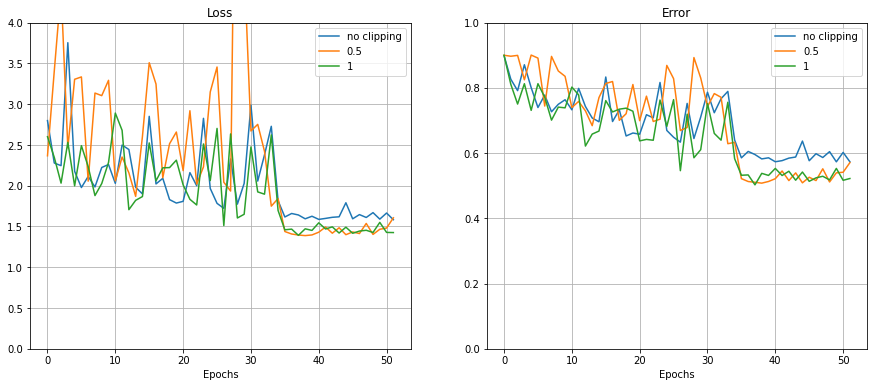

In [ ]:
plot_final_graph()

### decomposition_rank = 10

#### Model without clipping

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.ConvDecomposed2D, decomposition_rank=10)
model.summary()

Learning rate:  0.001
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_decomposed2d_33 (ConvDecom (None, 32, 32, 16)   455         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_62 (BatchNo (None, 32, 32, 16)   64          conv_decomposed2d_33[0][0]       
__________________________________________________________________________________________________
activation_62 (Activation)      (None, 32, 32, 16)   0           batch_normalization_62[0][0]     
______________________________________________________________________

In [ ]:
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'R_10_trainHistoryDict', steps_per_epoch=100, batch_size=100,
                       epochs=1000)

Using real-time data augmentation.
Epoch 1/1000
Learning rate:  0.001
100/100 [==============================] - 17s 104ms/step - loss: 4.6892 - acc: 0.1496 - val_loss: 2.6677 - val_acc: 0.1744

Epoch 00001: val_acc improved from -inf to 0.17440, saving model to /content/saved_models/cifar10_ResNet32v1_model.001.h5
Epoch 2/1000
Learning rate:  0.001
100/100 [==============================] - 8s 84ms/step - loss: 2.2539 - acc: 0.2909 - val_loss: 2.4542 - val_acc: 0.2234

Epoch 00002: val_acc improved from 0.17440 to 0.22340, saving model to /content/saved_models/cifar10_ResNet32v1_model.002.h5
Epoch 3/1000
Learning rate:  0.001
100/100 [==============================] - 8s 84ms/step - loss: 2.1281 - acc: 0.3480 - val_loss: 2.4055 - val_acc: 0.2761

Epoch 00003: val_acc improved from 0.22340 to 0.27610, saving model to /content/saved_models/cifar10_ResNet32v1_model.003.h5
Epoch 4/1000
Learning rate:  0.001
100/100 [==============================] - 8s 84ms/step - loss: 2.0601 - acc: 0.37

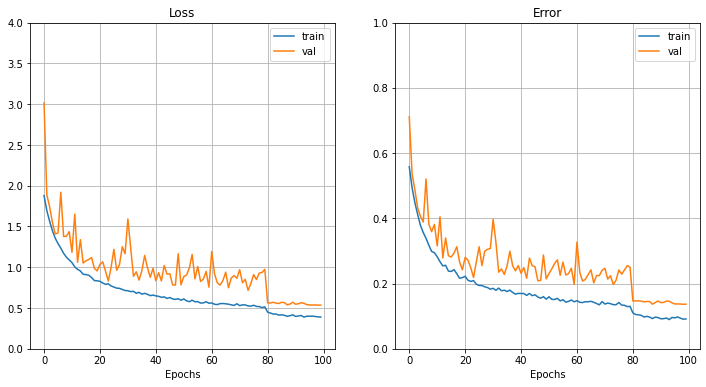

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('R_10_trainHistoryDict', "rb"))
functions.plot_loss_acc(history, 4, 1)

In [ ]:
1 - history['val_acc'][-1]

0.13679999113082886

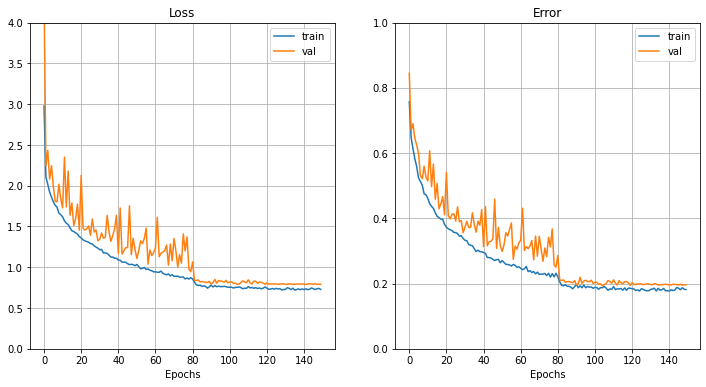

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('R_10_trainHistoryDict', "rb"))
functions.plot_loss_acc(history, 4, 1)

In [ ]:
1 - history['val_acc'][-1]

0.19609999656677246

#### Model with clipping to 0.5

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.ConvDecomposed2D, decomposition_rank=10)

Learning rate:  0.001


In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(0.5)]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'R_10_trainHistoryDict_clip_05', steps_per_epoch=100,
                       batch_size=100, epochs=500,
                       callbacks=callbacks)

Using real-time data augmentation.
Epoch 1/500
Learning rate:  0.001
100/100 [==============================] - 49s 101ms/step - loss: 4.8202 - acc: 0.1309 - val_loss: 10.7019 - val_acc: 0.1046

Epoch 00001: val_acc improved from -inf to 0.10460, saving model to /content/saved_models/cifar10_ResNet32v1_model.001.h5
Epoch 2/500
Learning rate:  0.001
100/100 [==============================] - 9s 86ms/step - loss: 2.1939 - acc: 0.1986 - val_loss: 2.3995 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.10460
Epoch 3/500
Learning rate:  0.001
100/100 [==============================] - 9s 85ms/step - loss: 1.8520 - acc: 0.3308 - val_loss: 2.4127 - val_acc: 0.1000

Epoch 00003: val_acc did not improve from 0.10460
Epoch 4/500
Learning rate:  0.001
100/100 [==============================] - 8s 84ms/step - loss: 1.7193 - acc: 0.3862 - val_loss: 2.5158 - val_acc: 0.1000

Epoch 00004: val_acc did not improve from 0.10460
Epoch 5/500
Learning rate:  0.001
100/100 [===================

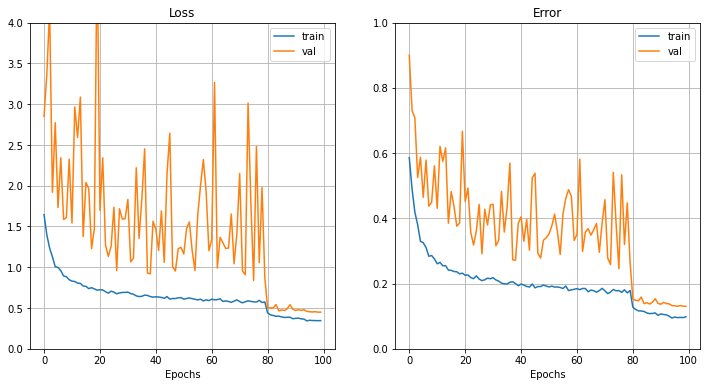

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('R_10_trainHistoryDict_clip_05', "rb"))
functions.plot_loss_acc(history, 4, 1)

In [ ]:
1 - history['val_acc'][-1]

0.12999999523162842

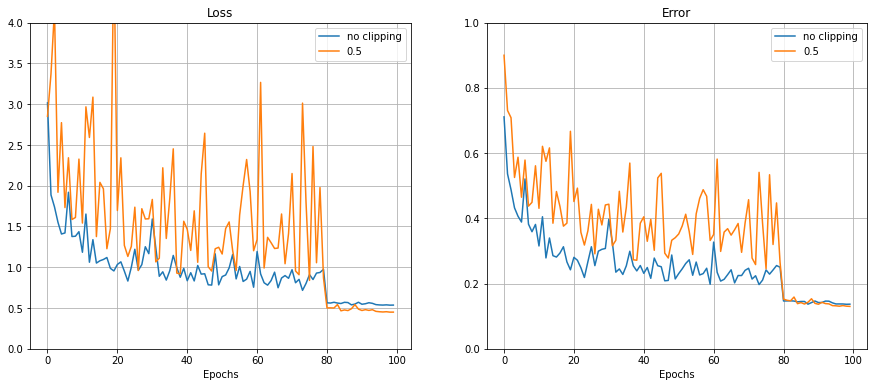

In [ ]:
plot_final_graph("R_10_", False)